# State abstraction beyond exactitude

In the previous notebook, we've illustrated the notion of state equivalence, and shown that we can simplify planning by identifying redundant states. This is quite useful, but also limited: we can't reduce the MDP more beyond equivalent states. That might not be enough if we are dealing with a very large state space. In the previous notebook, despite reduction of the state space, we still have 1200 states to deal with, which is not little.

Bisimulation is a very specific kind of state abstraction, it is the only exact approach that ensures that the value function remains exactly the same when computed on the reduced state space <a name="bib_ref-1"></a>[<sup>[1]</sup>](#bib_ref-1). That's quite handy, but again if the reduced MDP we obtain is still too large to compute for whatever system we are investigating, then we're still stuck. We can however reduce the state space further to compute the action plan. This will result in inaccurate value functions and therefore sub-optimal policies, but better sub-optimal policies than no policies at all. We have two ways to do so:

- Heuristic state abstraction
- Algorithmic state abstraction

The first option refers to simply pretending the MDP is smaller than it actually is to compute our value function. In other words, it consists of ignoring certain aspects of the problem, hoping that they don't matter quite that much for the overall return. In our specific task, we could for example consider that there are only two possible rewards: high and low, essentially splitting rewards in two groups and take the average reward in each group, acting as if our problem only had these two rewards. We can then compute the value function and optimal policy on the reduced state space and see how much return we get using that policy. The returns with such a policy will be below what we would have gotten using the optimal policy calculated on the full MDP, but hopefully it will be good enough (i.e. at least better than completely stochastic behaviour, otherwise what's the point of any computations). 

The second approach consists of reducing the state space by finding states that are similar in terms of their 

We can use state abstraction to simplify things further than what's feasible through bisimulation. Importantly though, any abstraction beyond removal of fully equivalent states means that the computation of the value and state action value functions will be off. We enter the realm of trade-offs between complexity and accuracy. As the brain's processing capacity is limited, it most likely sacrifices optimal behaviour in favor of computation tractability and is therefore is search for the best solution it can affords the computation of. 

There are two distinct ways in which state abstraction can be achieved (the name we came up with ourselves):
- Heuristic state abstraction
- Metric based state abstraction

The former consists of imposing equivalence between states by "deciding" on which aspects of the problem to focus on for planning. For example, we could imagine that in our specific task, participants decide to ignore the fact that there are two different costs in the task and plan **as if** everything costs the same. Alternatively, participants might plan **as if** energy didn't matter. 

The latter consists of determining based on the transition probability and the reward matrices to determine states similiarity to merge only states that are close together. We will see about this second approach in the next notebook and focus on heuristic state abstraction for now

## Heuristic state abstraction

To simplify the planning, we can decide on some aspects of the task to ignore. In our task, participants try to maximize the return, which requires them to make sure they have enough energy to accept the reward. As we have seen in the two previous notebooks, to get the maximal possible reward, participants need to take into accout their current energy level, the cost and value of the current offer, but also the cost of future rewards, as well as the trial number. For example, when in the last trial of the first segment, the decision will be different compared to the first trial of a segment for matched energy and reward, because participants know that the costs in the next segment is going to change. If the cost in the next segment is going to increase, when we have low energy and get a medium reward at a low cost in the last trial of the segment, we might decide to accept the reward by fear of not being able to afford a similar reward once the cost increases, whereas we might have rejected it in the first trial of the block. 

To simplify planning, participants might decide to take their decision based solely on their current energy level and the offer being present, discarding any temporal information. Such a heuristic implies that participants consider that all states with the same offer and costs are equivalent regardless of the trial number and future cost. To pretend that the problem does not contain these additional parameters, we can construct a transition probability and a reward matrix that omits them. We could construct this matrix from scratch, by adjusting the list of if statements we had created before. But as it turns out, we can also start from the transition probability and reward matrix from the full MDP and group the states that have the same offer, energy and current cost, but differ in their time and future cost and average over those. This is what we did in the previous notebook to collapse equivalent states. It works in this case as well, because to ignore certain aspects of the design, we can take the average of the tp and reward across all levels of the variable (note that we won't be writing all the code in the notebook to keep things concise):

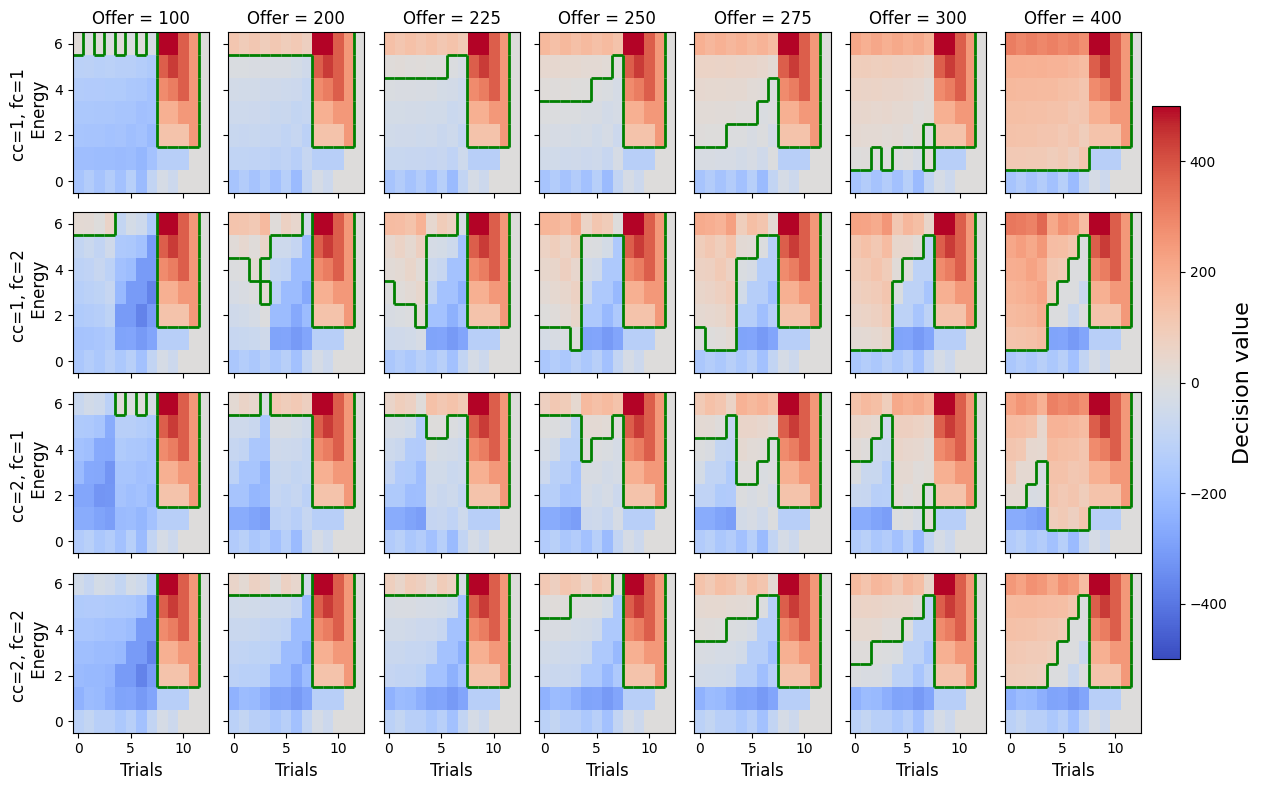

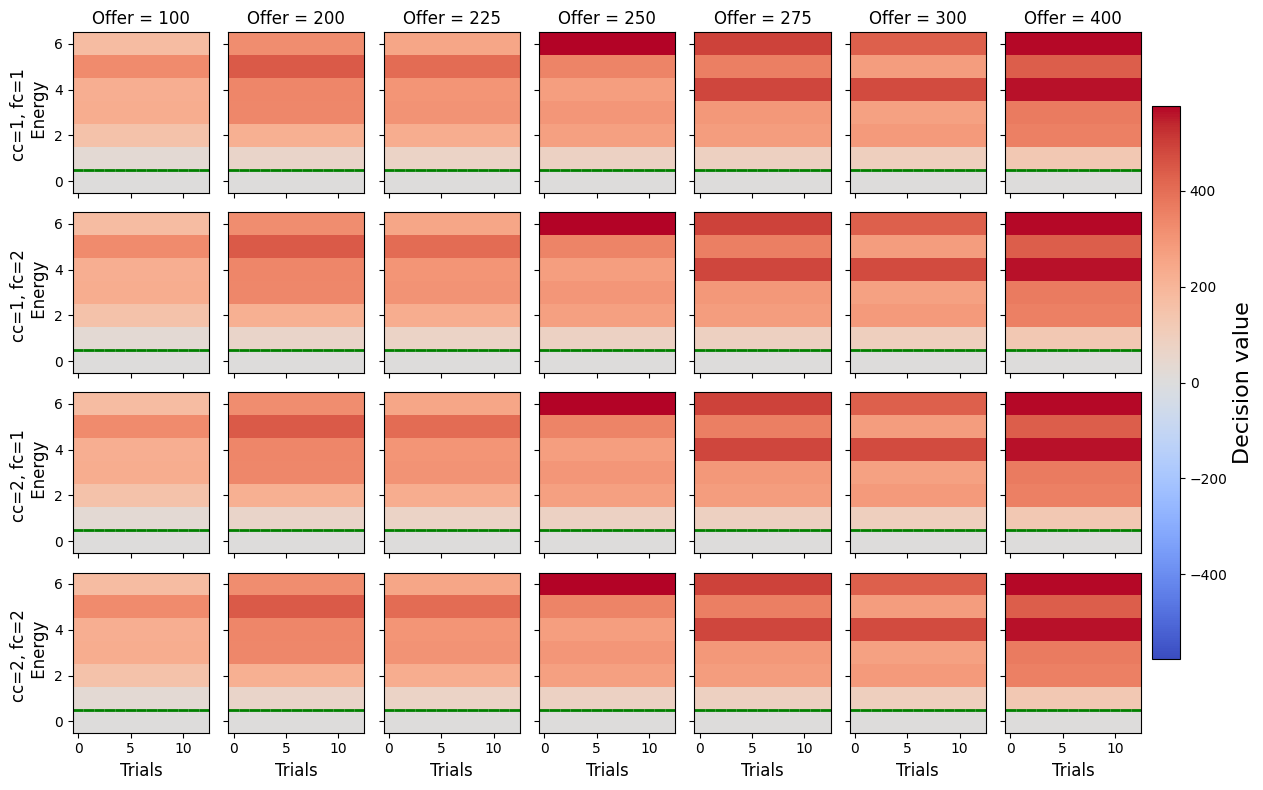

In [ ]:
import numpy as np

from utils import aggregate_states, avg_reduce_mdp, reduced2full_value, group_var
from MarkovDecisionProcess import MDP
from TaskConfig import LimitedEnergyTask
import matplotlib.pyplot as plt


# Create the task and its parameters (transition probability, reward...):
task = LimitedEnergyTask(tmax=12, energy_bonus=0)
task.build()

# Create the full MDP
task_mdp = MDP(task.states, task.tp, task.r, s2i=task.s2i)
# Solve the full MDP:
V_full, Q_full = task_mdp.backward_induction()

# Create state classes, where each class contain all states with same
# energy, offer, current cost but all future costs and time possible:
states_not_nofc = list(set([state[0:2] for state in task_mdp.states]))
states_classes = []
for state_r in states_not_nofc:
    class_ = []
    for state in task_mdp.states:
        if state[0:2] == state_r:
            class_.append(state)
    states_classes.append(class_)
        
# Reduce the MDP accordingly:
statesR, tpR, rR, class_of_state = avg_reduce_mdp(states_classes, task_mdp.tp, task_mdp.r, task_mdp.s2i)

# Create reduced MDP:
task_mdp_reduced = MDP(statesR, tpR, rR)
# Solve the MDP:
V_R, Q_R = task_mdp_reduced.backward_induction()
# Project back to full space:
_, Q_from_reduced = reduced2full_value(class_of_state, V_R, Q_R)
# Plot the decision values:
task_mdp.plot_dv(Q_full[:, 1]-Q_full[:, 0], tmax=12)
task_mdp.plot_dv(Q_from_reduced[:, 1]-Q_from_reduced[:, 0], tmax=12)
plt.show()

Obviously, removing time and future cost have a strong influence on the decision value. The optimal behaviour determined based on the reduced MDP departs strongly from the optimal behaviour obtained on the full MDP. As mentioned above, this is completely expected: as soon as we reduce the MDP further than state equivalence, we can't obtain the exact value function of our problem, only an inaccurate version of it. How inaccurate depends not only on the number of states we aggregate together but also on which exact states, depending on the reward and transition probability of these states (but we will get back to these points).

Concretely, that means that the expected return (i.e. sum of the reward over the course of the experiment) will always be lower when the optimal policy is computed based on the reduced vs. full MDP. We can compute the expected return with both to illustrate that point:

In [2]:
U_full = task_mdp.expected_return(np.array(Q_full[:, 1] - Q_full[:, 0] > 0).astype(int), initial_energy=3)
U_reduced = task_mdp.expected_return(np.array(Q_from_reduced[:, 1] - Q_from_reduced[:, 0] > 0).astype(int), initial_energy=3)
print(f"Expected return under full policy: {U_full:.2f}")
print(f"Expected return under reduced policy: {U_reduced:.2f}")

Expected return under full policy: 1994.42
Expected return under reduced policy: 887.50


We can see that while ignoring certain aspects of the state space reduced the size of the MDP making computation easier, we also loose quite a lot in terms of accuracy of the value function and as a result, we have quite bad return. We can try to aggregate a different aspect of the MDP. Let's try instead to reduce the MDP by grouping together pairs of reward (consider that reward 100 and 200 are about the same and so on)

In [1]:
# Group pairs of rewards:
rewards_pairs = group_var(task.O)[0]

states_classes = []
# Loop through each state:
for state in task_mdp.states:
    # Loop through each group
    for p in rewards_pairs:
        if state[1] == p[0]:
            states_classes.append([tuple(list(state[:1]) + [v] + list(state[1+1:])) for v in p]) 
            break

# Reduce the MDP:
statesR, tpR, rR, class_of_state = avg_reduce_mdp(states_classes, task_mdp.tp, task_mdp.r, task_mdp.s2i)
# Create reduced MDP:
task_mdp_reduced = MDP(statesR, tpR, rR)
# Solve the MDP:
V_R, Q_R = task_mdp_reduced.backward_induction()
# Project back to full space:
_, Q_from_reduced = reduced2full_value(class_of_state, V_R, Q_R)

# Plot the decision values:
task_mdp.plot_dv(Q_full[:, 1]-Q_full[:, 0])
task_mdp.plot_dv(Q_from_reduced[:, 1]-Q_from_reduced[:, 0])
plt.show()
U_full = task_mdp.expected_return(np.array(Q_full[:, 1] - Q_full[:, 0] > 0).astype(int), initial_energy=3)
U_reduced = task_mdp.expected_return(np.array(Q_from_reduced[:, 1] - Q_from_reduced[:, 0] > 0).astype(int), initial_energy=3)
print(f"Expected return under full policy: {U_full:.2f}")
print(f"Expected return under reduced policy: {U_reduced:.2f}")

NameError: name 'group_var' is not defined

In this case, the reduction of the MDP does not lead to a very drastic loss of expected value as was the case before. This might be because we have lumped fewer states together. Let's compare what would happen if we also lump only pairs of time points:

KeyboardInterrupt: 

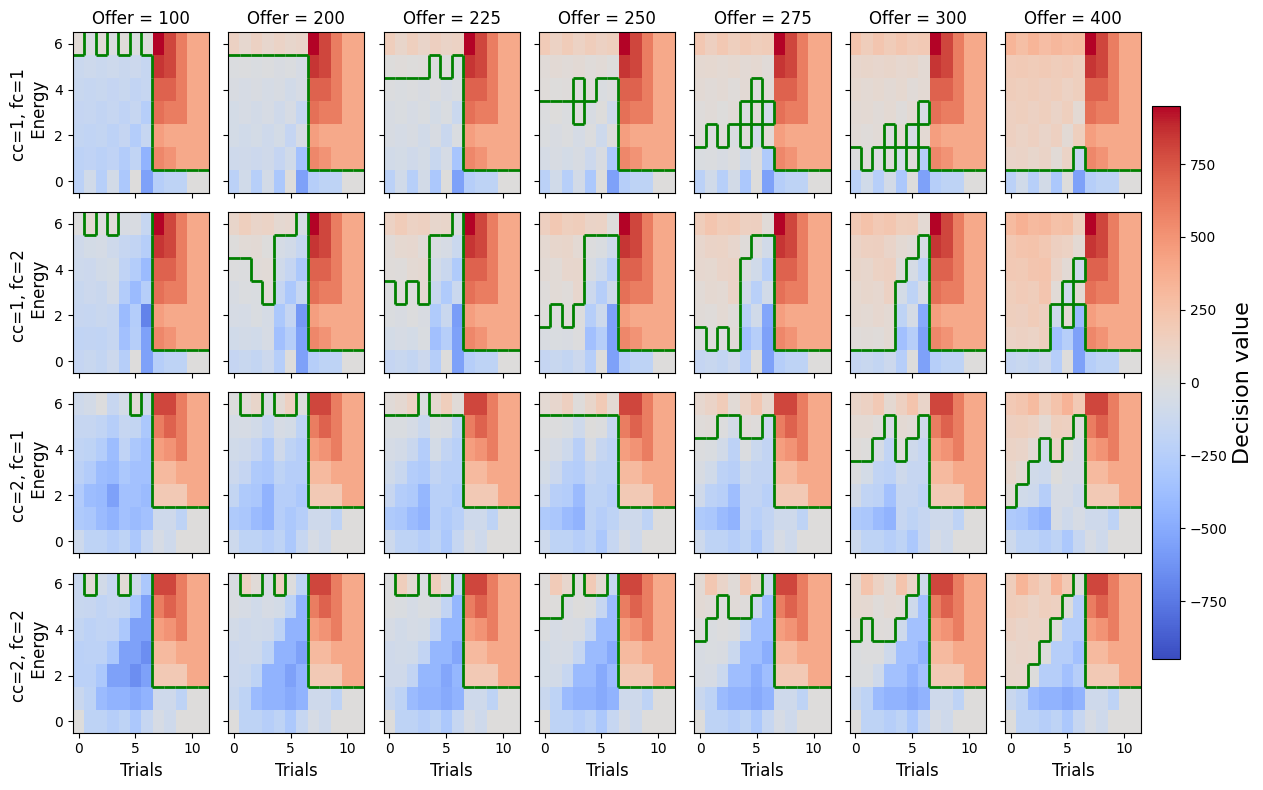

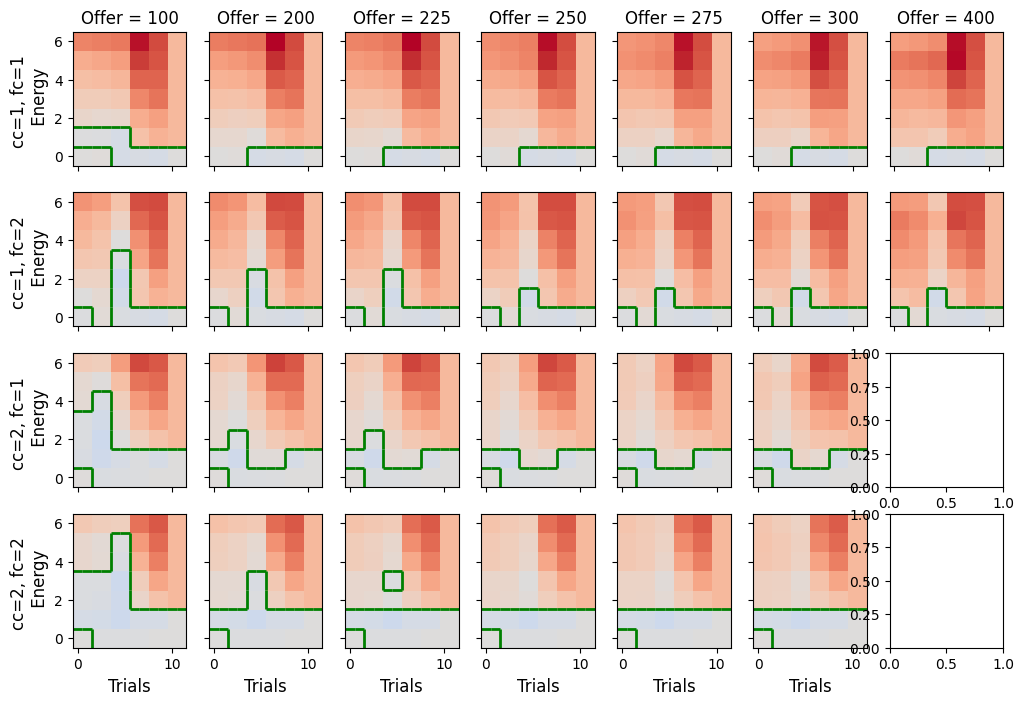

In [4]:
# Group pairs of rewards:
t_pairs = group_var(task.T)[0]

states_classes = []
# Loop through each state:
for state in task_mdp.states:
    # Loop through each group
    for t in t_pairs:
        if state[4] == t[0]:
            states_classes.append([tuple(list(state[:4]) + [v] + list(state[4+1:])) for v in t]) 
            break

# Reduce the MDP:
statesR, tpR, rR, class_of_state = avg_reduce_mdp(states_classes, task_mdp.tp, task_mdp.r, task_mdp.s2i)
# Create reduced MDP:
task_mdp_reduced = MDP(statesR, tpR, rR)
# Solve the MDP:
V_R, Q_R = task_mdp_reduced.backward_induction()
# Project back to full space:
_, Q_from_reduced = reduced2full_value(class_of_state, V_R, Q_R)

# Plot the decision values:
task_mdp.plot_dv(Q_full[:, 1]-Q_full[:, 0])
task_mdp.plot_dv(Q_from_reduced[:, 1]-Q_from_reduced[:, 0])
plt.show()
U_full = task_mdp.expected_return(np.array(Q_full[:, 1] - Q_full[:, 0] > 0).astype(int), initial_energy=3)
U_reduced = task_mdp.expected_return(np.array(Q_from_reduced[:, 1] - Q_from_reduced[:, 0] > 0).astype(int), initial_energy=3)
print(f"Expected return under full policy: {U_full:.2f}")
print(f"Expected return under reduced policy: {U_reduced:.2f}")

It is not just a question of how much we have reduced the MDP. We can see that when we aggregate time points together, we get a larger loss in expected return compared to combining rewards. This entails that not all aspects of the MDP when it comes to aggregating states. We can try to find which aspect has the strongest impact by reducing the MDP along all dimensions, and lumping all possible groupings of states together (for time for example, we can group pairs of time points: [1, 2], [3, 4]... but also triplets [1, 2, 3], [4, 5, 6]... and so on). We can then for each reduced MDP compute the expected return (relative to the max return) as a function of the size of the MDP:

In [ ]:
# Lists to store results:
abstraction_variable = []
abstraction_size = []
abstraction_level = []
abstraction_score = []
variables_names = ["energy", "offers", "current cost", "future cost", "t"]

# Loop over each dimensions of the state space:
for var_i in range(len(task_mdp.states[0])):
    print(f"aggregating {variables_names[var_i]}")
    for groups in aggregate_states(task_mdp.states, var_i):
        print(f"Lumps size: {len(groups[0])}")
        # Reduce the MDP:
        statesR, tpR, rR, class_of_state = avg_reduce_mdp(groups, task_mdp.tp, task_mdp.r, task_mdp.s2i)
        # Create reduced MDP:
        task_mdp_reduced = MDP(statesR, tpR, rR)
        # Solve the MDP:
        V_R, Q_R = task_mdp_reduced.backward_induction()
        # Project back to full space:
        _, Q_from_reduced = reduced2full_value(class_of_state, V_R, Q_R)
        # Compute score:
        abstraction_score.append(task_mdp.expected_return(task_mdp.greedy_policy(Q_from_reduced), initial_energy=3) / U_full)
        abstraction_variable.append(variables_names[var_i])
        abstraction_size.append(len(groups))
        abstraction_level.append(len(groups[0]))

# Convert to numpy arrays:
abstraction_size = np.array(abstraction_size)
abstraction_score = np.array(abstraction_score)
abstraction_variable = np.array(abstraction_variable)


aggregating energy
Lumps size: 2
Lumps size: 3
Lumps size: 4
Lumps size: 7
aggregating offers
Lumps size: 2
Lumps size: 3
Lumps size: 4
Lumps size: 7
aggregating current cost
Lumps size: 2
aggregating future cost
Lumps size: 2
aggregating t
Lumps size: 2
Lumps size: 3
Lumps size: 4
Lumps size: 5
Lumps size: 6
Lumps size: 7
Lumps size: 12


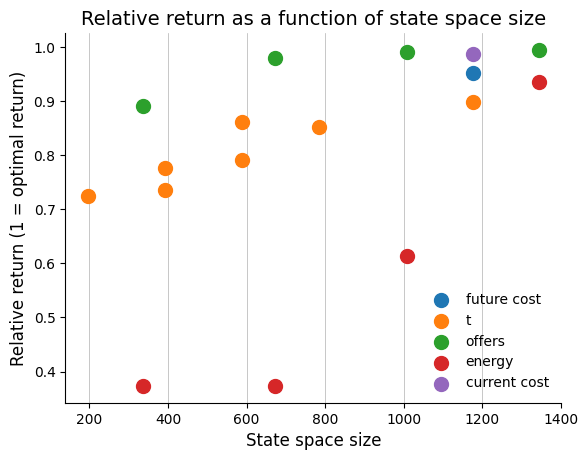

In [ ]:

# Plot the results:
fig, ax = plt.subplots()
for var_i, var in enumerate(list(set(abstraction_variable))):
    ax.scatter(abstraction_size[abstraction_variable == var], 
               abstraction_score[abstraction_variable == var], 
               label=f'{var}',s=100,zorder=1000)
ax.legend(frameon=False)
ax.set_ylabel('Relative return (1 = optimal return)', fontsize=12)
ax.set_xlabel('State space size', fontsize=12)
ax.set_title('Relative return as a function of state space size', fontsize=14)
ax.spines[['right', 'top']].set_visible(False)
ax.grid(axis="x", linewidth=0.5)
plt.show()


We can clearly see in this graph that not all variables are created equal when it comes to heuristic state abstraction. For energy, we an almost exponetial decay of the expected return, whereby the return doesn't decrease too much when we lump pairs of energy levels, but decrease very quickly thereafter. By contrast, the return remains quite good even when we average all rewards together. Of course, the goal of state abstraction is to reduce the state space all while trying to retain as much of the max possible return possible. 

With heuristic abstraction method, to decide which variable to aggregate and by how much, we need to try all possible reduction (as we did above) and select whichever dimension yields to the best compromise between reduction of state space and maintenance of as much of the return as possible. In the paper by Kabel and colleagues <a name="bib_ref-1"></a>[<sup>[1]</sup>](#bib_ref-1), they propose a metric called value of representation (VOR), which consists of the Expected return from a reduced MDP - the size of the reduced state space to identify MDP reductions that are the most advantageous, and select the reduction of the MDP that maximizes that metric. In our case:

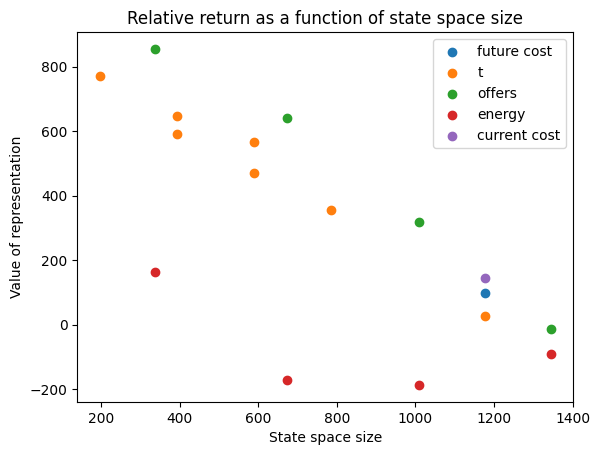

In [ ]:
vor = abstraction_score * U_full - abstraction_size
fig, ax = plt.subplots()
for var_i, var in enumerate(list(set(abstraction_variable))):
    ax.scatter(abstraction_size[abstraction_variable == var], vor[abstraction_variable == var], label=f'{var}')
ax.legend()
ax.set_ylabel('Value of representation')
ax.set_xlabel('State space size')
ax.set_title('Relative return as a function of state space size')
plt.show()

According to this metric, we should use the reduced MDP in which we lump together all offers as it yields the largest VOR, that is it leads to the best trade off between expected return and size of the MDP.

# Limitations of heuristic state abstraction
The approach of heuristic state space abstraction is a bit limited, because it consists of essentially blindly reducing the state space, computing the resulting value function and then evaluate it on the full MDP again and comparing it to other possible abstraction. It is completely ignoring the transition probability and reward function of the MDP in question. We have however seen in the previous notebook that the equivalence of states depends on these two key parameters of the MDP. So if instead we could leverage these properties to compute state abstraction, we can perform state space abstraction in a more directed fashion, aggregating states together based on how much they will impact the resulting value function.

This will be the topic of the next notebook.

# Bibliography
<a name="bib_ref-1"></a>[<sup>[1]</sup>](#bib_ref-1) Ho, M. K., Abel, D., Correa, C. G., Littman, M. L., Cohen, J. D., & Griffiths, T. L. (2022). People construct simplified mental representations to plan. Nature, 606(7912), 129-136.